In [2]:
import xarray as xr
from scipy.interpolate import griddata
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# Using Antwerp Ghent and Charleroi as training set
# Brussels as testing set

In [3]:
cities = ['Antwerp','Charleroi','Ghent']
urbclim_and_feature_files = {}
era5_files = {}
for city in cities:
    urbclim_and_feature_files[city] = pd.read_csv(f'/Users/wangy/Documents/MACS/Thesis/Urbclim_and_feature/{city}_urbclim_and_features_2015_07_01to10.csv',index_col=0)
    era5_files[city] = pd.read_csv(f'/Users/wangy/Documents/MACS/Thesis/ERA5_variables/{city}/ERA5_2015_07_01to10_{city}_Corrected_v2.csv',index_col=0)

print(urbclim_and_feature_files)
print(era5_files)

{'Antwerp':                          time          y         x        tas  AHF_Antwerp.nc  \
0                  2015-07-01  51.101140  4.204696  21.213068        4.658679   
1                  2015-07-01  51.101210  4.206120  21.115869        4.658679   
2                  2015-07-01  51.101284  4.207544  21.071832        4.658679   
3                  2015-07-01  51.101353  4.208968  20.965753        4.061239   
4                  2015-07-01  51.101425  4.210392  20.114313        4.061239   
...                       ...        ...       ...        ...             ...   
21744235  2015-07-10 23:00:00  51.390260  4.594774  18.087183        1.723335   
21744236  2015-07-10 23:00:00  51.390324  4.596208  18.089258        1.723335   
21744237  2015-07-10 23:00:00  51.390392  4.597641  18.045221        1.723335   
21744238  2015-07-10 23:00:00  51.390457  4.599074  17.997308        1.723335   
21744239  2015-07-10 23:00:00  51.390526  4.600507  17.911432        1.723335   

          Coast

In [4]:
# Add the time feature into the df

def add_time_feature(all_variables):
    all_variables['time'] = pd.to_datetime(all_variables['time'], format='mixed')
    # Extract the hour of the day
    all_variables['hour'] = all_variables['time'].dt.hour
    # Convert time features using sin and cos
    all_variables['hour_sin'] = np.sin(2 * np.pi * all_variables['hour'] / 24)
    all_variables['hour_cos'] = np.cos(2 * np.pi * all_variables['hour'] / 24)
    
    # Extract the day of the year
    # all_variables['day_of_year'] = all_variables['time'].dt.dayofyear
    # Convert time features using sin and cos
    # df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    # df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
    # print(all_variables[['time', 'hour',  'hour_sin', 'hour_cos']])


In [5]:
# Add the same time features to different city df
for df in urbclim_and_feature_files.values():
    add_time_feature(df)
    

In [6]:
# This function is to combine the preprocessed urbclim data, features data and era5 data
def combine_all_features(urbclim_and_feature, era5):
    era5_new = era5.drop(columns=['x','y','time','t2m'])
    # display(era5_new.columns)
    # urbclim_and_feature = urbclim_and_feature.drop(columns=['Unnamed: 0', 'y.1', 'x.1'])
    # display(urbclim_and_feature.columns)
    all_variables = pd.concat([urbclim_and_feature,era5_new], axis=1)
    display(all_variables)
    return all_variables
    

In [7]:
# combine urbclim_feature and era5 for each city
for city in urbclim_and_feature_files.keys():
    if city in era5_files:  
        df1 = urbclim_and_feature_files[city]
        df2 = era5_files[city]
        combined_df = combine_all_features(df1, df2)  
        # update the file in urbclim_and_feature_files dict
        urbclim_and_feature_files[city] = combined_df  
    else:
        print(f"Warning: {city} not found in era5_files")


time          y         x        tas  AHF_Antwerp.nc  \
0        2015-07-01 00:00:00  51.101140  4.204696  21.213068        4.658679   
1        2015-07-01 00:00:00  51.101210  4.206120  21.115869        4.658679   
2        2015-07-01 00:00:00  51.101284  4.207544  21.071832        4.658679   
3        2015-07-01 00:00:00  51.101353  4.208968  20.965753        4.061239   
4        2015-07-01 00:00:00  51.101425  4.210392  20.114313        4.061239   
...                      ...        ...       ...        ...             ...   
21744235 2015-07-10 23:00:00  51.390260  4.594774  18.087183        1.723335   
21744236 2015-07-10 23:00:00  51.390324  4.596208  18.089258        1.723335   
21744237 2015-07-10 23:00:00  51.390392  4.597641  18.045221        1.723335   
21744238 2015-07-10 23:00:00  51.390457  4.599074  17.997308        1.723335   
21744239 2015-07-10 23:00:00  51.390526  4.600507  17.911432        1.723335   

          Coast_Antwerp.nc  LCZcorine_Antwerp_UrbClim_2015_01_v1.0.nc  \
0                      NaN                                       23.0   
1                      NaN                                       23.0   
2                      NaN                                       23.0   
3                      NaN                                       23.0   
4                      NaN                                       23.0   
...                    ...                                        ...   
21744235      23985.864120                                        NaN   
21744236      24129.855469                                        NaN   
21744237      24129.855469                                        NaN   
21744238      24129.855469                                        NaN   
21744239      24129.855469                                        NaN   

          elevation_Antwerp_UrbClim_2015_01_v1.0.nc  height_Antwerp.nc  \
0                                       1273.298927                0.0   
1                                       1321.636086                0.0   
2                                        511.150639                0.0   
3                                        618.075115                0.0   
4                                       1422.742444                0.0   
...                                             ...                ...   
21744235                                        NaN                NaN   
21744236                                        NaN                NaN   
21744237                                        NaN                NaN   
21744238                                        NaN                NaN   
21744239                                        NaN                NaN   

          imperv_Antwerp_UrbClim_2015_01_v1.0.nc  ...  cape         kx  \
0                                            0.0  ...   0.0  13.754264   
1                                            0.0  ...   0.0  13.747570   
2                                            0.0  ...   0.0  13.740907   
3                                            0.0  ...   0.0  13.734209   
4                                            0.0  ...   0.0  13.727532   
...                                          ...  ...   ...        ...   
21744235                                     NaN  ...   0.0  19.700962   
21744236                                     NaN  ...   0.0  19.702003   
21744237                                     NaN  ...   0.0  19.703057   
21744238                                     NaN  ...   0.0  19.704100   
21744239                                     NaN  ...   0.0  19.705158   

                   ssr            str             sp           sshf       tcc  \
0         2.328306e-10 -256114.947653  101580.269309  183056.466441  0.000000   
1         2.328306e-10 -256111.919335  101580.487905  183056.122678  0.000000   
2         2.328306e-10 -256108.833158  101580.709235  183055.719100  0.000000   
3         2.328306e-10 -256105.820257  101580.927067  183055.389959  0.000000   
4  

time          y         x        tas  AHF_Charleroi.nc  \
0       2015-07-01 00:00:00  50.321007  4.309057  19.767511          1.689140   
1       2015-07-01 00:00:00  50.321075  4.310457  19.166986          1.689140   
2       2015-07-01 00:00:00  50.321148  4.311858  19.185938          1.689140   
3       2015-07-01 00:00:00  50.321217  4.313258  16.801355          1.689140   
4       2015-07-01 00:00:00  50.321285  4.314659  16.825250          1.689140   
...                     ...        ...       ...        ...               ...   
9696235 2015-07-10 23:00:00  50.513588  4.563002  14.409479          2.720522   
9696236 2015-07-10 23:00:00  50.513653  4.564408  14.469568          2.720522   
9696237 2015-07-10 23:00:00  50.513720  4.565815  16.376978          2.720522   
9696238 2015-07-10 23:00:00  50.513786  4.567221  17.275903          2.720522   
9696239 2015-07-10 23:00:00  50.513850  4.568628  17.265802          2.720522   

         Coast_Charleroi.nc  LCZcorine_Charleroi_UrbClim_2015_01_v1.0.nc  \
0                       NaN                                          2.0   
1                       NaN                                          2.0   
2                       NaN                                         18.0   
3                       NaN                                         18.0   
4                       NaN                                         18.0   
...                     ...                                          ...   
9696235                 NaN                                          NaN   
9696236                 NaN                                          NaN   
9696237                 NaN                                          NaN   
9696238                 NaN                                          NaN   
9696239                 NaN                                          NaN   

         elevation_Charleroi_UrbClim_2015_01_v1.0.nc  height_Charleroi.nc  \
0                                      147737.014659             0.465045   
1                                      145967.478708             0.253712   
2                                      148024.153233             0.007804   
3                                      148395.251593             0.000000   
4                                      148698.251097             0.000000   
...                                              ...                  ...   
9696235                                          NaN                  NaN   
9696236                                          NaN                  NaN   
9696237                                          NaN                  NaN   
9696238                                          NaN                  NaN   
9696239                                          NaN                  NaN   

         imperv_Charleroi_UrbClim_2015_01_v1.0.nc  ...  cape         kx  \
0                                       21.407955  ...   0.0   3.434648   
1                                        7.730673  ...   0.0   3.442519   
2                                        0.000000  ...   0.0   3.450436   
3                                        0.000000  ...   0.0   3.458316   
4                                        0.000000  ...   0.0   3.466191   
...                                           ...  ...   ...        ...   
9696235                                       NaN  ...   0.0  11.425128   
9696236                                       NaN  ...   0.0  11.431603   
9696237                                       NaN  ...   0.0  11.438103   
9696238                                       NaN  ...   0.0  11.444591   
9696239                                       NaN  ...   0.0  11.451052   

                  ssr            str            sp           sshf       tcc  \
0        2.328306e-10 -258863.286824  99655.583379  186570.069134  0.000000   
1        2.328306e-10 -258859.309246  99655.030658  186567.725299  0.000000   
2        2.328306e-10 -258855.320114  99654.494278  186565.074764  0.00000

time          y         x        tas  \
0        2015-07-01 00:00:00  50.956380  3.559364  20.159906   
1        2015-07-01 00:00:00  50.956455  3.560782  20.364038   
2        2015-07-01 00:00:00  50.956535  3.562201  20.339746   
3        2015-07-01 00:00:00  50.956615  3.563619  20.933466   
4        2015-07-01 00:00:00  50.956696  3.565038  20.894647   
...                      ...        ...       ...        ...   
15120235 2015-07-10 23:00:00  51.199123  3.878829  14.714990   
15120236 2015-07-10 23:00:00  51.199196  3.880256  14.702997   
15120237 2015-07-10 23:00:00  51.199272  3.881682  14.713770   
15120238 2015-07-10 23:00:00  51.199350  3.883109  14.694849   
15120239 2015-07-10 23:00:00  51.199420  3.884535  14.691827   

          population_Ghent.nc  LCZcorine_Ghent_UrbClim_2015_01_v1.0.nc  \
0                    3.479522                                     21.0   
1                    0.027388                                     21.0   
2                    0.000000                                     21.0   
3                    0.066312                                      3.0   
4                    0.630084                                      3.0   
...                       ...                                      ...   
15120235                  NaN                                      NaN   
15120236                  NaN                                      NaN   
15120237                  NaN                                      NaN   
15120238                  NaN                                      NaN   
15120239                  NaN                                      NaN   

          LCZ_Ghent_UrbClim_2015_01_v1.0.nc  Coast_Ghent.nc  \
0                                      14.0             NaN   
1                                      14.0             NaN   
2                                      14.0             NaN   
3                                      14.0             NaN   
4                                      17.0             NaN   
...                                     ...             ...   
15120235                               14.0             NaN   
15120236                               14.0             NaN   
15120237                               14.0             NaN   
15120238                               14.0             NaN   
15120239                                9.0             NaN   

          elevation_Ghent_UrbClim_2015_01_v1.0.nc  \
0                                    12946.355164   
1                                    12679.174408   
2                                    14924.397436   
3                                    11269.822635   
4                                     8275.092036   
...                                           ...   
15120235                                      NaN   
15120236                                      NaN   
15120237                                      NaN   
15120238                                      NaN   
15120239                                      NaN   

          imperv_Ghent_UrbClim_2015_01_v1.0.nc  ...  cape         kx  \
0                                     0.000000  ...   0.0  13.698739   
1                                     1.053982  ...   0.0  13.707487   
2                                    26.266093  ...   0.0  13.716321   
3                                    17.922689  ...   0.0  13.725155   
4                                     3.570645  ...   0.0  13.734005   
...                                        ...  ...   ...        ...   
15120235                                   NaN  ...   0.0  16.657769   
15120236                                   NaN  ...   0.0  16.664531   
15120237                                   NaN  ...   0.0  16.671316   
15120238                                   NaN  ...   0.0  16.678118   
15120239                                   NaN  ...   0.0  16.684853   

                   ssr            str             sp           sshf       tcc  \
0         2.328306e-10 -25

In [8]:
# Sample the data
# Random version
def sample_data(df):
    # Sample each group and extract one-third of the rows
    grouped = df.groupby('time', group_keys=False)
    sampled = grouped.apply(lambda group: group.sample(frac = 1/20, random_state=42))
    
    # Reset indexes to avoid multiple indexes when grouping
    sampled = sampled.reset_index(drop=True)
    display(sampled)
    return sampled


In [ ]:
# Sample the data
# Cut small squares version
def sample_data(df):
    # Group by timestamp
    grouped = df.groupby('time', group_keys=False)
    
    # Calculate the latitude and longitude range for each group and filter
    sampled = grouped.apply(lambda group: sample_group(group))
    
    # Reset the index to avoid multi-level indexing
    sampled = sampled.reset_index(drop=True)
    
    # Display the results
    display(sampled)
    return sampled

def sample_group(group):
    # Get the latitude and longitude range of the current group
    lat_min = group['y'].min()
    lat_max = group['y'].max() - 0.1  # 避免范围溢出
    lon_min = group['x'].min()
    lon_max = group['x'].max() - 0.1  # 避免范围溢出
    
    # 如果当前组的经纬度范围不足以随机生成，直接返回空
    if lat_min >= lat_max or lon_min >= lon_max:
        return group.iloc[[]]  # 返回空 DataFrame
    
    # Randomly generate the latitude and longitude range of the current group
    lat_start = np.random.uniform(lat_min, lat_max)
    lat_end = lat_start + 0.1
    lon_start = np.random.uniform(lon_min, lon_max)
    lon_end = lon_start + 0.1
    
    # Filter out rows that match a random range
    filtered_group = group[
        (group['y'] >= lat_start) &
        (group['y'] <= lat_end) &
        (group['x'] >= lon_start) &
        (group['x'] <= lon_end)
    ]
    
    return filtered_group


In [9]:
for city in urbclim_and_feature_files.keys():
    df = urbclim_and_feature_files[city]
    df_new = sample_data(df)
    # Update the urbclim_and_feature_files dict
    urbclim_and_feature_files[city] = df_new


/var/folders/bv/rfp6znxd6qqbmjm5bhtmkw4m0000gn/T/ipykernel_41380/3907951677.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled = grouped.apply(lambda group: group.sample(frac = 1/20, random_state=42))


time          y         x        tas  AHF_Antwerp.nc  \
0       2015-07-01 00:00:00  51.332417  4.513800  20.664545        8.555087   
1       2015-07-01 00:00:00  51.336610  4.264203  19.721277       16.555870   
2       2015-07-01 00:00:00  51.212650  4.515183  22.342126        8.922057   
3       2015-07-01 00:00:00  51.311340  4.227067  20.765131        2.570885   
4       2015-07-01 00:00:00  51.312443  4.285940  21.813562        9.389531   
...                     ...        ...       ...        ...             ...   
1087195 2015-07-10 23:00:00  51.331160  4.430457  18.936060        7.382403   
1087196 2015-07-10 23:00:00  51.257670  4.552918  18.360620        4.669188   
1087197 2015-07-10 23:00:00  51.221992  4.541352  18.863489        8.922057   
1087198 2015-07-10 23:00:00  51.339024  4.387743  17.821832        4.668962   
1087199 2015-07-10 23:00:00  51.312500  4.569421  18.190332        4.004476   

         Coast_Antwerp.nc  LCZcorine_Antwerp_UrbClim_2015_01_v1.0.nc  \
0            17846.568359                                       21.0   
1             1818.640032                                       43.0   
2            23820.942030                                        3.0   
3             4500.000000                                       12.0   
4             4743.416504                                       37.0   
...                   ...                                        ...   
1087195      12369.317383                                        2.0   
1087196      22896.505859                                        2.0   
1087197      24225.435115                                       21.0   
1087198       9123.353409                                       21.0   
1087199      22321.513672                                        2.0   

         elevation_Antwerp_UrbClim_2015_01_v1.0.nc  height_Antwerp.nc  \
0                                     26465.488976           0.013173   
1                                         0.000000           0.000000   
2                                      6505.325352           3.595983   
3                                       529.723076           0.000000   
4                                      4281.430829           0.009319   
...                                            ...                ...   
1087195                               18487.753046           0.196690   
1087196                               11512.207793           1.846281   
1087197                                7834.563396           0.471359   
1087198                               10988.660118           0.002838   
1087199                               30745.794642           0.130893   

         imperv_Antwerp_UrbClim_2015_01_v1.0.nc  ...  cape         kx  \
0                                      0.000000  ...   0.0  13.333500   
1                                      0.000000  ...   0.0  14.793607   
2                                     80.113107  ...   0.0  12.925625   
3                                      0.000000  ...   0.0  14.924988   
4                                      1.138197  ...   0.0  14.592812   
...                                         ...  ...   ...        ...   
1087195                                0.000000  ...   0.0  19.402796   
1087196                                9.682263  ...   0.0  19.234521   
1087197                                0.000000  ...   0.0  18.976216   
1087198                                0.000000  ...   0.0  19.358378   
1087199                                1.797300  ...   0.0  19.423887   

                  ssr            str             sp           sshf       tcc  \
0        2.328306e-10 -261182.029065  101673.279369  185846.541624  0.004802   
1        2.328306e-10 -254322.323986  101703.518292  176471.302899  0.005223   
2        2.328306e-10 -261638.229069  101641.178035  185178.451433  0.000000   
3        2.328306e-10 -253723.925018  101700.773078  177339.575796  0.003699   
4        2.328306e-10 -255032.973607  101696.280704  17

/var/folders/bv/rfp6znxd6qqbmjm5bhtmkw4m0000gn/T/ipykernel_41380/3907951677.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled = grouped.apply(lambda group: group.sample(frac = 1/20, random_state=42))


time          y         x        tas  AHF_Charleroi.nc  \
0      2015-07-01 00:00:00  50.422108  4.572145  19.922845          6.573756   
1      2015-07-01 00:00:00  50.341614  4.565893  18.685358          2.827497   
2      2015-07-01 00:00:00  50.399520  4.420949  17.164056         17.362085   
3      2015-07-01 00:00:00  50.378094  4.351547  19.689783          7.946384   
4      2015-07-01 00:00:00  50.394424  4.408854  19.812250         15.785686   
...                    ...        ...       ...        ...               ...   
484795 2015-07-10 23:00:00  50.380276  4.451435  13.719019         17.362085   
484796 2015-07-10 23:00:00  50.338703  4.467589  14.515894          2.467472   
484797 2015-07-10 23:00:00  50.340946  4.365854  13.427820          2.592276   
484798 2015-07-10 23:00:00  50.354390  4.550328  16.079065          2.827497   
484799 2015-07-10 23:00:00  50.414840  4.495357  16.938898         15.519547   

        Coast_Charleroi.nc  LCZcorine_Charleroi_UrbClim_2015_01_v1.0.nc  \
0            105383.592089                                          2.0   
1            114162.877474                                         23.0   
2            105469.269738                                         21.0   
3            107094.578125                                          2.0   
4            105883.195312                                          2.0   
...                    ...                                          ...   
484795       108167.695312                                         20.0   
484796       112715.963653                                         20.0   
484797       111635.570312                                         12.0   
484798       112614.390625                                          2.0   
484799       105148.703125                                         27.0   

        elevation_Charleroi_UrbClim_2015_01_v1.0.nc  height_Charleroi.nc  \
0                                     120890.124783             0.527123   
1                                     255698.641608             0.000000   
2                                     127460.152298             0.240160   
3                                     116622.982213             1.376275   
4                                     140232.393856             1.809474   
...                                             ...                  ...   
484795                                149578.862325             0.390413   
484796                                230663.051513             0.392436   
484797                                199604.414196             0.000000   
484798                                194619.080220             0.569518   
484799                                125723.606571             0.114249   

        imperv_Charleroi_UrbClim_2015_01_v1.0.nc  ...  cape        kx  \
0                                      47.055537  ...   0.0  5.100198   
1                                       0.000000  ...   0.0  4.628338   
2                                       8.347268  ...   0.0  4.472854   
3                                      47.169396  ...   0.0  4.155817   
4                                      32.199755  ...   0.0  4.421783   
...                                          ...  ...   ...       ...   
484795                                  1.738831  ...   0.0  9.061775   
484796                                  9.444955  ...   0.0  8.589456   
484797                                  0.000000  ...   0.0  8.085189   
484798                                 12.600057  ...   0.0  9.193924   
484799                                  0.000000  ...   0.0  9.793398   

                 ssr            str            sp           sshf       tcc  \
0       2.328306e-10 -256574.034904  99761.013351  177896.582071  0.000000   
1       2.328306e-10 -257232.767582  99537.283654  183917.901786  0.000000   
2       2.328306e-10 -258010.158285  99818.815608  180989.501485  0.000000   
3       2.328306e-10 -258630.513804  99821.706586  183116.

/var/folders/bv/rfp6znxd6qqbmjm5bhtmkw4m0000gn/T/ipykernel_41380/3907951677.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled = grouped.apply(lambda group: group.sample(frac = 1/20, random_state=42))


time          y         x        tas  \
0      2015-07-01 00:00:00  51.150740  3.715921  19.313928   
1      2015-07-01 00:00:00  50.980984  3.744718  21.193750   
2      2015-07-01 00:00:00  51.128193  3.535350  20.608972   
3      2015-07-01 00:00:00  51.078136  3.707188  22.611078   
4      2015-07-01 00:00:00  51.115738  3.752248  20.373376   
...                    ...        ...       ...        ...   
755995 2015-07-10 23:00:00  51.124294  3.660715  16.624323   
755996 2015-07-10 23:00:00  51.065052  3.551365  15.466638   
755997 2015-07-10 23:00:00  51.119267  3.767546  18.476678   
755998 2015-07-10 23:00:00  51.140090  3.685806  15.237726   
755999 2015-07-10 23:00:00  51.134712  3.837187  14.772607   

        population_Ghent.nc  LCZcorine_Ghent_UrbClim_2015_01_v1.0.nc  \
0                  4.593147                                     27.0   
1                 34.110625                                      2.0   
2                  0.749199                                     12.0   
3                 27.358407                                      2.0   
4                  7.567728                                     40.0   
...                     ...                                      ...   
755995             6.488735                                     20.0   
755996             0.000000                                     20.0   
755997             4.423150                                      5.0   
755998             3.706859                                     20.0   
755999             0.592821                                     20.0   

        LCZ_Ghent_UrbClim_2015_01_v1.0.nc  Coast_Ghent.nc  \
0                                     9.0    20615.527344   
1                                     6.0    38947.250206   
2                                     9.0    27744.544103   
3                                     6.0    29231.832031   
4                                    17.0    23769.728516   
...                                   ...             ...   
755995                                6.0    24698.177734   
755996                               14.0    33615.472656   
755997                                8.0    23537.205078   
755998                               14.0    22610.837891   
755999                               14.0    21503.317721   

        elevation_Ghent_UrbClim_2015_01_v1.0.nc  \
0                                  11786.650656   
1                                  21691.920864   
2                                  21269.929347   
3                                   9057.604615   
4                                   1845.577003   
...                                         ...   
755995                              5755.650410   
755996                              7786.030295   
755997                             10197.547908   
755998                              4930.972569   
755999                              3206.158729   

        imperv_Ghent_UrbClim_2015_01_v1.0.nc  ...  cape         kx  \
0                                   0.114402  ...   0.0  16.379380   
1                                  38.033065  ...   0.0  15.095362   
2                                   1.465297  ...   0.0  15.561329   
3                                  28.832745  ...   0.0  15.798905   
4                                  27.964944  ...   0.0  16.288320   
...                                      ...  ...   ...        ...   
755995                             13.208849  ...   0.0  15.273449   
755996                              0.000000  ...   0.0  14.500934   
755997                             75.274131  ...   0.0  15.565613   
755998                              7.438143  ...   0.0  15.472589   
755999                             10.746958  ...   0.0  15.951510   

                 ssr            str             sp           sshf       tcc  \
0       2.328306e-10 -253071.562630  101628.896392  177184.393420  0.000000   
1       2.328306e-10 -258263.254083  101454.719379  181966.403176  

In [14]:
def standardize_columns(columns):
    return [col.replace('_Brussels', '').replace('_Antwerp', '').replace('_Ghent', '').replace('_Charleroi', '') for col in columns]

for city in urbclim_and_feature_files.keys():
    df = urbclim_and_feature_files[city]
    df.columns = standardize_columns(df.columns)
  
# Select the column order of Antwerp df as the basis
base_columns = urbclim_and_feature_files['Antwerp'].columns

# Adjust the column order of df2 and df3 to be consistent with df1
urbclim_and_feature_files['Ghent'] = urbclim_and_feature_files['Ghent'][base_columns]
urbclim_and_feature_files['Charleroi'] = urbclim_and_feature_files['Charleroi'][base_columns]


print("df1 columns:", urbclim_and_feature_files['Ghent'].columns)
print("df2 columns:", urbclim_and_feature_files['Charleroi'].columns)


df1 columns: Index(['time', 'y', 'x', 'tas', 'AHF.nc', 'Coast.nc',
       'LCZcorine_UrbClim_2015_01_v1.0.nc',
       'elevation_UrbClim_2015_01_v1.0.nc', 'height.nc',
       'imperv_UrbClim_2015_01_v1.0.nc', 'LCZ_UrbClim_2015_01_v1.0.nc',
       'population.nc', 'surface.nc', 'volume.nc', 'hour', 'hour_sin',
       'hour_cos', 'u10', 'v10', 'blh', 'cape', 'kx', 'ssr', 'str', 'sp',
       'sshf', 'tcc', 'tcw', 'tp', 't2m_corrected'],
      dtype='object')
df2 columns: Index(['time', 'y', 'x', 'tas', 'AHF.nc', 'Coast.nc',
       'LCZcorine_UrbClim_2015_01_v1.0.nc',
       'elevation_UrbClim_2015_01_v1.0.nc', 'height.nc',
       'imperv_UrbClim_2015_01_v1.0.nc', 'LCZ_UrbClim_2015_01_v1.0.nc',
       'population.nc', 'surface.nc', 'volume.nc', 'hour', 'hour_sin',
       'hour_cos', 'u10', 'v10', 'blh', 'cape', 'kx', 'ssr', 'str', 'sp',
       'sshf', 'tcc', 'tcw', 'tp', 't2m_corrected'],
      dtype='object')


In [15]:
# combine 3 city files together to obtain the final training set
training_set = pd.concat([
    urbclim_and_feature_files['Antwerp'],
    urbclim_and_feature_files['Charleroi'],
    urbclim_and_feature_files['Ghent']
], ignore_index=True)
print(training_set)

                       time          y         x        tas     AHF.nc  \
0       2015-07-01 00:00:00  51.332417  4.513800  20.664545   8.555087   
1       2015-07-01 00:00:00  51.336610  4.264203  19.721277  16.555870   
2       2015-07-01 00:00:00  51.212650  4.515183  22.342126   8.922057   
3       2015-07-01 00:00:00  51.311340  4.227067  20.765131   2.570885   
4       2015-07-01 00:00:00  51.312443  4.285940  21.813562   9.389531   
...                     ...        ...       ...        ...        ...   
2327995 2015-07-10 23:00:00  51.124294  3.660715  16.624323   4.097389   
2327996 2015-07-10 23:00:00  51.065052  3.551365  15.466638   1.848006   
2327997 2015-07-10 23:00:00  51.119267  3.767546  18.476678  12.412785   
2327998 2015-07-10 23:00:00  51.140090  3.685806  15.237726   3.653433   
2327999 2015-07-10 23:00:00  51.134712  3.837187  14.772607   3.380833   

             Coast.nc  LCZcorine_UrbClim_2015_01_v1.0.nc  \
0        17846.568359                              

#### leave out AHF and only keep the night data.

In [16]:
training_set_selected = training_set.drop(columns = {"AHF.nc", "elevation_UrbClim_2015_01_v1.0.nc"})
# Filter time range 22:00 to 4:00 the next day
# training_set_selected = training_set_selected[(training_set_selected['hour'] >= 22) | (training_set_selected['hour'] < 4)]
training_set_selected.to_csv("/Users/wangy/Documents/MACS/Thesis/train_set/train_set_3_cities_2015.csv")

In [14]:
# delete all the NaN value here
training_set_selected.dropna(inplace=True)
training_set_selected.reset_index(drop=True, inplace=True)

y_train = pd.DataFrame()
# Calculate the residue
y_train['residue'] = training_set_selected['tas'] - training_set_selected['t2m_corrected']

X_train = training_set_selected.drop(columns=['x','y','time','tas','hour'])


In [15]:
display(y_train)
display(X_train.columns)
X_train.info()

residue
0       -1.708993
1       -1.099557
2       -0.510508
3       -1.659840
4       -1.387941
...           ...
2324635  0.648722
2324636  0.153920
2324637  0.909329
2324638  0.331478
2324639  0.231375

[2324640 rows x 1 columns]

Index(['Coast.nc', 'LCZcorine_UrbClim_2015_01_v1.0.nc', 'height.nc',
       'imperv_UrbClim_2015_01_v1.0.nc', 'LCZ_UrbClim_2015_01_v1.0.nc',
       'population.nc', 'surface.nc', 'volume.nc', 'hour_sin', 'hour_cos',
       'u10', 'v10', 'blh', 'cape', 'kx', 'ssr', 'str', 'sp', 'sshf', 'tcc',
       'tcw', 'tp', 't2m_corrected'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2324640 entries, 0 to 2324639
Data columns (total 23 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   Coast.nc                           float64
 1   LCZcorine_UrbClim_2015_01_v1.0.nc  float64
 2   height.nc                          float64
 3   imperv_UrbClim_2015_01_v1.0.nc     float64
 4   LCZ_UrbClim_2015_01_v1.0.nc        float64
 5   population.nc                      float64
 6   surface.nc                         float64
 7   volume.nc                          float64
 8   hour_sin                           float64
 9   hour_cos                           float64
 10  u10                                float64
 11  v10                                float64
 12  blh                                float64
 13  cape                               float64
 14  kx                                 float64
 15  ssr                                float64
 16  str               

In [17]:
urbclim_and_feature = pd.read_csv('/Users/wangy/Documents/MACS/Thesis/Urbclim_and_feature/Brussels_urbclim_and_features_2017_07_01to03.csv')
era5 = pd.read_csv('/Users/wangy/Documents/MACS/Thesis/ERA5_variables/Brussels/ERA5_2017_07_01to03_Brussels_Corrected_v1.csv')

urbclim_and_feature = urbclim_and_feature.drop(columns=[ 'Unnamed: 0'])
era5_new = era5.drop(columns=['x','y','time','Unnamed: 0','t2m'])
test_set = pd.concat([urbclim_and_feature,era5_new], axis=1)
add_time_feature(test_set)

# Adjust the column order of test set
test_set.columns = standardize_columns(test_set.columns)
base_columns = urbclim_and_feature_files['Antwerp'].columns
test_set = test_set[base_columns]

In [18]:
test_set_selected = test_set.drop(columns = {"AHF.nc","elevation_UrbClim_2015_01_v1.0.nc"})
# Filter time range 22:00 to 4:00 the next day
# test_set_selected = test_set_selected[(test_set_selected['hour'] >= 22) | (test_set_selected['hour'] < 4)]

# delete all the NaN value here
test_set_selected.dropna(inplace=True)
test_set_selected.reset_index(drop=True, inplace=True)

test_set_selected.to_csv("/Users/wangy/Documents/MACS/Thesis/test_set/test_set_brussels_2017.csv")

In [ ]:
y_test = pd.DataFrame()
# Calculate the residue
y_test['residue'] = test_set_selected['tas'] - test_set_selected['t2m_corrected']
X_test = test_set_selected.drop(columns=['x','y','time','tas','hour'])

print(X_test.columns)

In [19]:
# draw the trend of tas and t2m
def plot_tem_over_time(df,city):
    plt.figure(figsize=(12, 6))
    plt.plot(df['time'], df['tas'], label='TAS (Temperature)', color='blue', linestyle='-', linewidth=1)
    plt.plot(df['time'], df['t2m_corrected'], label='T2M Corrected', color='orange', linestyle='--', linewidth=1)
    plt.legend()
    plt.title(f'Temperature Trends Over Time {city}', fontsize=16)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Temperature (°C)', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

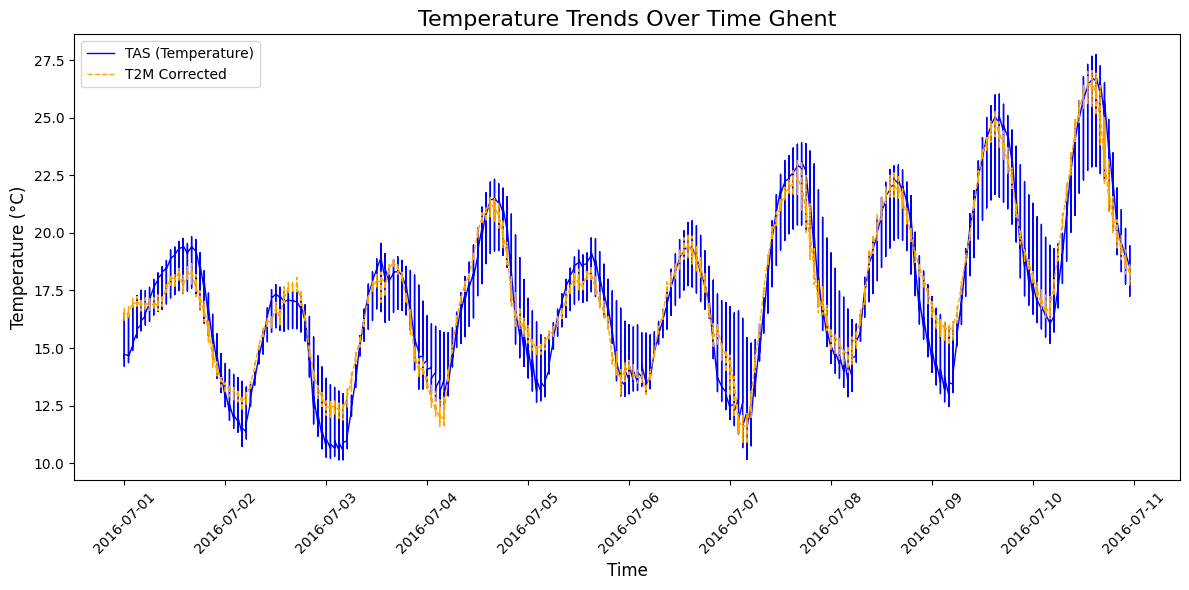

In [20]:
plot_tem_over_time(urbclim_and_feature_files['Antwerp'],'Antwerp')
plot_tem_over_time(urbclim_and_feature_files['Ghent'],'Ghent')
plot_tem_over_time(urbclim_and_feature_files['Charleroi'],'Charleroi')
plot_tem_over_time(test_set,'Brussels')

In [21]:
print(y_train)
print(X_train)
print(y_test)
print(X_test)

          residue
0       -1.708993
1       -1.099557
2       -0.510508
3       -1.659840
4       -1.387941
...           ...
2324635  0.648722
2324636  0.153920
2324637  0.909329
2324638  0.331478
2324639  0.231375

[2324640 rows x 1 columns]
             Coast.nc  LCZcorine_UrbClim_2015_01_v1.0.nc  height.nc  \
0        17846.568359                               21.0   0.013173   
1         1818.640032                               43.0   0.000000   
2        23820.942030                                3.0   3.595983   
3         4500.000000                               12.0   0.000000   
4         4743.416504                               37.0   0.009319   
...               ...                                ...        ...   
2324635  24698.177734                               20.0   0.273453   
2324636  33615.472656                               20.0   0.000000   
2324637  23537.205078                                5.0   4.883322   
2324638  22610.837891                         

In [18]:
def plot_y(df, model_name, feature_name):
  plt.figure(figsize=(10, 8))
  plt.scatter(df['x'], df['y'], c=df[feature_name], cmap='viridis', s=1, vmin = 13, vmax = 19)  # 使用 'viridis' 色彩映射
  # plt.scatter(df['x'], df['y'], c=df[feature_name], cmap='viridis', s=1)
  plt.colorbar(label= feature_name)
  plt.xlabel('Longitude (x)')
  plt.ylabel('Latitude (y)')
  plt.title(f'Geographical Distribution of Temperature - {model_name}')
  plt.show()

In [19]:
def plot_residue(df, model_name, feature_name):
  plt.figure(figsize=(10, 8))
  plt.scatter(df['x'], df['y'], c=df[feature_name], cmap='viridis', s=1, vmin = 0, vmax = 3)
  plt.colorbar(label= feature_name)
  plt.xlabel('Longitude (x)')
  plt.ylabel('Latitude (y)')
  plt.title(f'Geographical Distribution of Temperature Residue - {model_name}')
  plt.show()

In [24]:
linear_model = LinearRegression()
# X_train = X_train.drop(columns = ['Unnamed: 0'])
linear_model.fit(X_train, y_train)
# X_test = X_test.drop(columns = ['hour'])

# Predict y
y_pred_lr = linear_model.predict(X_test)
y_pred_lr = pd.DataFrame(y_pred_lr, columns=['residue'])
print(y_pred_lr)

          residue
0        1.077537
1        0.990647
2        0.805085
3        0.763466
4        0.755523
...           ...
6519379  0.077945
6519380 -0.095056
6519381  0.240196
6519382  0.169202
6519383 -0.075808

[6519384 rows x 1 columns]


In [26]:
y_pred_lr[['y','x','time']] = test_set_selected[['y','x','time']]
y_pred_lr_day = y_pred_lr[(y_pred_lr['time'].dt.hour >= 6) & (y_pred_lr['time'].dt.hour < 18)]
y_pred_lr_night = y_pred_lr[(y_pred_lr['time'].dt.hour < 6) | (y_pred_lr['time'].dt.hour >= 18)]

y_test[['y','x','time']] = test_set_selected[['y','x','time']]
y_test_day = y_test[(y_test['time'].dt.hour >= 6) & (y_test['time'].dt.hour < 18)]
y_test_night = y_test[(y_test['time'].dt.hour < 6) | (y_test['time'].dt.hour >= 18)]

print(y_pred_lr_day)
print(y_pred_lr_night)
print(y_test_day)
print(y_test_night)




          residue          y         x                time
543282   0.595595  50.700043  4.207803 2017-07-01 06:00:00
543283   0.508323  50.700110  4.209215 2017-07-01 06:00:00
543284   0.322384  50.700184  4.210626 2017-07-01 06:00:00
543285   0.280388  50.700256  4.212038 2017-07-01 06:00:00
543286   0.272064  50.700325  4.213450 2017-07-01 06:00:00
...           ...        ...       ...                 ...
5976097 -0.608215  50.986958  4.547782 2017-07-03 17:00:00
5976098 -0.782428  50.987026  4.549203 2017-07-03 17:00:00
5976099 -0.448392  50.987090  4.550624 2017-07-03 17:00:00
5976100 -0.520598  50.987160  4.552045 2017-07-03 17:00:00
5976101 -0.766823  50.987225  4.553465 2017-07-03 17:00:00

[3259692 rows x 4 columns]
          residue          y         x                time
0        1.077537  50.700043  4.207803 2017-07-01 00:00:00
1        0.990647  50.700110  4.209215 2017-07-01 00:00:00
2        0.805085  50.700184  4.210626 2017-07-01 00:00:00
3        0.763466  50.700256

In [20]:
# compute the errors
# compute MAE (Mean Absolute Error)
def calculate_errors(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Absolute Error (MAE): {mae}")
    
    # compute MSE (Mean Squared Error)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error (MSE): {mse}")
    
    # compute RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mse)
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    return mae, mse, rmse



In [28]:
print("Errors:")
calculate_errors(y_test['residue'], y_pred_lr['residue'])
print("Errors during day:")
calculate_errors(y_test_day['residue'], y_pred_lr_day['residue'])
print("Errors during night:")
calculate_errors(y_test_night['residue'], y_pred_lr_night['residue'])

Errors:
Mean Absolute Error (MAE): 1.0335843693055065
Mean Squared Error (MSE): 1.7502749001354445
Root Mean Squared Error (RMSE): 1.3229795539370381
R-squared (R²): -0.4071400212344003
Errors during day:
Mean Absolute Error (MAE): 0.9247366876550805
Mean Squared Error (MSE): 1.1972792959352385
Root Mean Squared Error (RMSE): 1.0942025845040024
R-squared (R²): -2.804992514561076
Errors during night:
Mean Absolute Error (MAE): 1.1424320509559323
Mean Squared Error (MSE): 2.3032705043356527
Root Mean Squared Error (RMSE): 1.5176529591232815
R-squared (R²): -0.31899044475230154


In [42]:
# sum up y_pred and corrected ERA5 to get the urbclim prediction
urbclim_pred_lr = pd.DataFrame()

urbclim_pred_lr['tas'] = y_pred_lr['residue'] + test_set_selected['t2m_corrected']
urbclim_pred_lr[['y','x','time']] = test_set_selected[['y','x','time']]

print(urbclim_pred_lr)

               tas          y         x                time
0        16.508490  50.700043  4.207803 2017-07-01 00:00:00
1        16.422416  50.700110  4.209215 2017-07-01 00:00:00
2        16.251131  50.700184  4.210626 2017-07-01 00:00:00
3        16.216643  50.700256  4.212038 2017-07-01 00:00:00
4        16.181892  50.700325  4.213450 2017-07-01 00:00:00
...            ...        ...       ...                 ...
6519379  15.482578  50.986958  4.547782 2017-07-03 23:00:00
6519380  15.328465  50.987026  4.549203 2017-07-03 23:00:00
6519381  15.665140  50.987090  4.550624 2017-07-03 23:00:00
6519382  15.585546  50.987160  4.552045 2017-07-03 23:00:00
6519383  15.344238  50.987225  4.553465 2017-07-03 23:00:00

[6519384 rows x 4 columns]


tas min:  -0.7274408023685943
tas max:  1.85672323364337


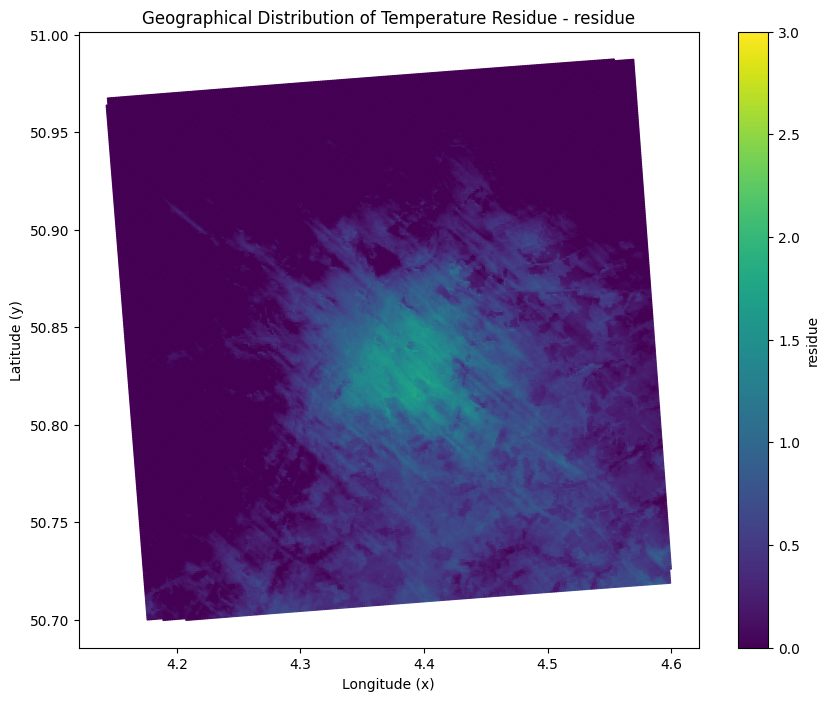

In [29]:
# Plot  residue 
residue_plot = y_test[(y_test['time']=="2017-07-01 12:00:00")]
# residue_plot = y_pred_lr[(y_pred_lr['time']=="2016-07-01 12:00:00")]

tas_min_lr = residue_plot['residue'].min()
tas_max_lr = residue_plot['residue'].max()
print("tas min: " ,tas_min_lr)
print("tas max: " ,tas_max_lr)
plot_residue(residue_plot, 'residue', 'residue')

In [58]:
# extract the first timestamp y_pred and plot it
# first_stamp_data = urbclim_pred[(urbclim_pred['time']=="2015-07-01 00:00:00") | (urbclim_pred['time']=="2015-07-01")]
first_stamp_data_lr = urbclim_pred_lr[(urbclim_pred_lr['time']=="2017-07-01 00:00:00")]
print(first_stamp_data_lr)
tas_min_lr = first_stamp_data_lr['tas'].min()
tas_max_lr = first_stamp_data_lr['tas'].max()
print("tas min: " ,tas_min_lr)
print("tas max: " ,tas_max_lr)
plot_y(first_stamp_data_lr, 'Linear regression - urbclim tas', 'tas')

             tas          y         x       time
0      16.508490  50.700043  4.207803 2017-07-01
1      16.422416  50.700110  4.209215 2017-07-01
2      16.251131  50.700184  4.210626 2017-07-01
3      16.216643  50.700256  4.212038 2017-07-01
4      16.181892  50.700325  4.213450 2017-07-01
...          ...        ...       ...        ...
90542  16.895577  50.986958  4.547782 2017-07-01
90543  16.740950  50.987026  4.549203 2017-07-01
90544  17.077120  50.987090  4.550624 2017-07-01
90545  16.997006  50.987160  4.552045 2017-07-01
90546  16.755191  50.987225  4.553465 2017-07-01

[90547 rows x 4 columns]
tas min:  15.225851379161462
tas max:  18.164148206476966


In [30]:
# Hyperparameter definition
input_size = X_train.shape[1]  
hidden_sizes = [100, 50, 10]  # hidden layer size
output_size = 1  
learning_rate = 0.001
epochs = 5
# early_stopping_patience = 2

In [31]:
from sklearn.preprocessing import MinMaxScaler
# Initialize the normalizer
scaler = MinMaxScaler(feature_range=(0, 1))

# Normalize the training set
X_train_normalized = scaler.fit_transform(X_train)

# Normalize the test set using the parameters of the training set
X_test_normalized = scaler.transform(X_test)

In [32]:
# Define the NN model
class NNmodel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NNmodel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[1], hidden_sizes[2]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[2], output_size)
        )
    
    def forward(self, x):
        return self.model(x)

In [33]:
# Create a model instance
model = NNmodel(input_size, hidden_sizes, output_size)
criterion = nn.MSELoss()  # Loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [34]:
# Data preparation
train_dataset = TensorDataset(torch.tensor(X_train_normalized, dtype=torch.float32), 
                               torch.tensor(y_train['residue'], dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(torch.tensor(X_test_normalized, dtype=torch.float32), 
                             torch.tensor(y_test['residue'], dtype=torch.float32))
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model training
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    # Model validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # patience_counter = 0
        best_model_state = model.state_dict()  # Save the Optimal result
    # else:
    #     patience_counter += 1
    #     if patience_counter >= early_stopping_patience:
    #         print("Early stopping triggered!")
    #         break




Epoch 1/5, Train Loss: 0.2449, Val Loss: 1.0527
Epoch 2/5, Train Loss: 0.1804, Val Loss: 1.1498
Epoch 3/5, Train Loss: 0.1669, Val Loss: 1.1957
Epoch 4/5, Train Loss: 0.1589, Val Loss: 1.2858
Epoch 5/5, Train Loss: 0.1535, Val Loss: 1.2649


In [35]:
# Load the optimal model
model.load_state_dict(best_model_state)

# Test set prediction
X_test_tensor = torch.tensor(X_test_normalized, dtype=torch.float32)
y_pred = model(X_test_tensor).detach().numpy()

# Transform into DataFrame
y_pred_df = pd.DataFrame(y_pred, columns=['residue'])
print(y_pred_df)

          residue
0        1.706955
1        1.289378
2        1.150568
3        1.139384
4        1.098132
...           ...
6519379  0.253640
6519380 -0.654804
6519381  0.034662
6519382  0.094076
6519383 -0.545756

[6519384 rows x 1 columns]


In [36]:
y_pred_nn = y_pred_df
y_pred_nn[['y','x','time']] = test_set_selected[['y','x','time']]

y_pred_nn_day = y_pred_nn[(y_pred_nn['time'].dt.hour >= 6) & (y_pred_nn['time'].dt.hour < 18)]
y_pred_nn_night = y_pred_nn[(y_pred_nn['time'].dt.hour < 6) | (y_pred_nn['time'].dt.hour >= 18)]

print(y_pred_nn_day)
print(y_pred_nn_night)

          residue          y         x                time
543282  -0.093835  50.700043  4.207803 2017-07-01 06:00:00
543283  -0.165672  50.700110  4.209215 2017-07-01 06:00:00
543284  -0.220423  50.700184  4.210626 2017-07-01 06:00:00
543285  -0.267059  50.700256  4.212038 2017-07-01 06:00:00
543286  -0.200051  50.700325  4.213450 2017-07-01 06:00:00
...           ...        ...       ...                 ...
5976097 -0.025298  50.986958  4.547782 2017-07-03 17:00:00
5976098 -0.057070  50.987026  4.549203 2017-07-03 17:00:00
5976099 -0.069899  50.987090  4.550624 2017-07-03 17:00:00
5976100 -0.088461  50.987160  4.552045 2017-07-03 17:00:00
5976101 -0.043683  50.987225  4.553465 2017-07-03 17:00:00

[3259692 rows x 4 columns]
          residue          y         x                time
0        1.706955  50.700043  4.207803 2017-07-01 00:00:00
1        1.289378  50.700110  4.209215 2017-07-01 00:00:00
2        1.150568  50.700184  4.210626 2017-07-01 00:00:00
3        1.139384  50.700256

In [37]:
calculate_errors(y_test['residue'], y_pred_nn['residue'])
print("Errors during day:")
calculate_errors(y_test_day['residue'], y_pred_nn_day['residue'])
print("Errors during night:")
calculate_errors(y_test_night['residue'], y_pred_nn_night['residue'])

Mean Absolute Error (MAE): 0.9301820277609725
Mean Squared Error (MSE): 1.2648970350410735
Root Mean Squared Error (RMSE): 1.1246764134812615
R-squared (R²): -0.01691867980812045
Errors during day:
Mean Absolute Error (MAE): 0.8887170456139011
Mean Squared Error (MSE): 1.0992414913503077
Root Mean Squared Error (RMSE): 1.0484471810016505
R-squared (R²): -2.49342518532043
Errors during night:
Mean Absolute Error (MAE): 0.9716470099080409
Mean Squared Error (MSE): 1.430552578731835
Root Mean Squared Error (RMSE): 1.1960570967691446
R-squared (R²): 0.18078003494978045


In [45]:
# Plot residue 
residue_plot = y_pred_nn[(y_pred_nn['time']=="2017-07-01 12:00:00")]

tas_min_lr = residue_plot['residue'].min()
tas_max_lr = residue_plot['residue'].max()
print("tas min: " ,tas_min_lr)
print("tas max: " ,tas_max_lr)
plot_residue(residue_plot, 'residue - NN model', 'residue')

tas min:  -2.690758
tas max:  2.6105874


In [57]:
# plot NN model predicted tas
urbclim_pred_nn = pd.DataFrame()

urbclim_pred_nn['tas'] = y_pred_nn['residue'] + test_set_selected['t2m_corrected']
urbclim_pred_nn[['y','x','time']] = test_set_selected[['y','x','time']]

print(urbclim_pred_nn)

first_stamp_data_nn = urbclim_pred_nn[(urbclim_pred_nn['time']=="2017-07-01 00:00:00")]
print(first_stamp_data_nn)
tas_min_nn = first_stamp_data_nn['tas'].min()
tas_max_nn = first_stamp_data_nn['tas'].max()
print("tas min: " ,tas_min_nn)
print("tas max: " ,tas_max_nn)
plot_y(first_stamp_data_nn, 'NN model - urbclim tas', 'tas')

               tas          y         x                time
0        17.137908  50.700043  4.207803 2017-07-01 00:00:00
1        16.721147  50.700110  4.209215 2017-07-01 00:00:00
2        16.596615  50.700184  4.210626 2017-07-01 00:00:00
3        16.592561  50.700256  4.212038 2017-07-01 00:00:00
4        16.524501  50.700325  4.213450 2017-07-01 00:00:00
...            ...        ...       ...                 ...
6519379  15.658273  50.986958  4.547782 2017-07-03 23:00:00
6519380  14.768717  50.987026  4.549203 2017-07-03 23:00:00
6519381  15.459606  50.987090  4.550624 2017-07-03 23:00:00
6519382  15.510420  50.987160  4.552045 2017-07-03 23:00:00
6519383  14.874291  50.987225  4.553465 2017-07-03 23:00:00

[6519384 rows x 4 columns]
             tas          y         x       time
0      17.137908  50.700043  4.207803 2017-07-01
1      16.721147  50.700110  4.209215 2017-07-01
2      16.596615  50.700184  4.210626 2017-07-01
3      16.592561  50.700256  4.212038 2017-07-01
4      

In [21]:
#use ANN model to predict the temp
from sklearn.neural_network import MLPRegressor


ann_model = MLPRegressor(hidden_layer_sizes=(100, 50, 10),
                                activation='relu',
                                solver='adam',
                                max_iter=100,
                                random_state=45,
                                early_stopping=True,
                                validation_fraction=0.1,
                                n_iter_no_change=20,
                                verbose=True,
                                alpha=0.03)



In [22]:
import matplotlib.pyplot as plt

# y_train = y_train.ravel()
ann_model.fit(X_train, y_train)

# Plot training loss
plt.plot(ann_model.loss_curve_)
plt.title("Training Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

y_pred_mlp = ann_model.predict(X_test)
y_pred_mlp = pd.DataFrame(y_pred_mlp, columns=['residue'])
print(y_pred_mlp)

/Users/wangy/Documents/MACS/Thesis/thesis_code/thesis_featurevisual/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 6161.72079897
Validation score: -19.948835
Iteration 2, loss = 10.00804611
Validation score: 0.073559
Iteration 3, loss = 0.55234602
Validation score: 0.326391
Iteration 4, loss = 0.56460639
Validation score: -0.000022
Iteration 5, loss = 0.56797839
Validation score: -0.000003
Iteration 6, loss = 0.65012095
Validation score: -0.000015
Iteration 7, loss = 0.56587540
Validation score: -0.000006
Iteration 8, loss = 0.56608569
Validation score: -0.000000
Iteration 9, loss = 0.56503437
Validation score: -0.000000
Iteration 10, loss = 0.55074708
Validation score: 0.113665
Iteration 11, loss = 0.40251230
Validation score: 0.349945
Iteration 12, loss = 0.36111459
Validation score: 0.388524
Iteration 13, loss = 0.34675325
Validation score: 0.390424
Iteration 14, loss = 0.34458044
Validation score: 0.333365
Iteration 15, loss = 0.34258885
Validation score: 0.408426
Iteration 16, loss = 0.34171286
Validation score: 0.379127
Iteration 17, loss = 0.34204190
Validation score: 0.4

          residue
0        1.088162
1       -0.153839
2       -0.021086
3        0.156777
4       -0.203875
...           ...
6519379  0.722796
6519380  0.380524
6519381 -0.003988
6519382  0.250203
6519383 -0.125694

[6519384 rows x 1 columns]


In [23]:
y_pred_mlp[['y','x','time']] = test_set_selected[['y','x','time']]

y_pred_mlp_day = y_pred_mlp[(y_pred_mlp['time'].dt.hour >= 6) & (y_pred_mlp['time'].dt.hour < 18)]
y_pred_mlp_night = y_pred_mlp[(y_pred_mlp['time'].dt.hour < 6) | (y_pred_mlp['time'].dt.hour >= 18)]

print(y_pred_mlp_day)
print(y_pred_mlp_night)


          residue          y         x                time
543282   0.125216  50.700043  4.207803 2017-07-01 06:00:00
543283  -0.464075  50.700110  4.209215 2017-07-01 06:00:00
543284  -0.316542  50.700184  4.210626 2017-07-01 06:00:00
543285  -0.109255  50.700256  4.212038 2017-07-01 06:00:00
543286  -0.514088  50.700325  4.213450 2017-07-01 06:00:00
...           ...        ...       ...                 ...
5976097  0.099596  50.986958  4.547782 2017-07-03 17:00:00
5976098 -0.062202  50.987026  4.549203 2017-07-03 17:00:00
5976099 -0.062557  50.987090  4.550624 2017-07-03 17:00:00
5976100 -0.035046  50.987160  4.552045 2017-07-03 17:00:00
5976101 -0.063367  50.987225  4.553465 2017-07-03 17:00:00

[3259692 rows x 4 columns]
          residue          y         x                time
0        1.088162  50.700043  4.207803 2017-07-01 00:00:00
1       -0.153839  50.700110  4.209215 2017-07-01 00:00:00
2       -0.021086  50.700184  4.210626 2017-07-01 00:00:00
3        0.156777  50.700256

In [24]:
# Plot residue 
residue_plot = y_pred_mlp[(y_pred_mlp['time']=="2017-07-01 00:00:00")]

tas_min_lr = residue_plot['residue'].min()
tas_max_lr = residue_plot['residue'].max()
print("tas min: " ,tas_min_lr)
print("tas max: " ,tas_max_lr)
plot_residue(residue_plot, 'residue - MLP model', 'residue')

tas min:  -0.5359604782750713
tas max:  2.6424424253941012


In [26]:
calculate_errors(y_test['residue'], y_pred_mlp['residue'])
print("Errors during day:")
calculate_errors(y_test_day['residue'], y_pred_mlp_day['residue'])
print("Errors during night:")
calculate_errors(y_test_night['residue'], y_pred_mlp_night['residue'])

Mean Absolute Error (MAE): 0.8676762031062413
Mean Squared Error (MSE): 1.4805282198515406
Root Mean Squared Error (RMSE): 1.2167695837139998
Errors during day:


In [67]:
# sum up y_pred and corrected ERA5 to get the urbclim prediction
urbclim_pred_mlp = pd.DataFrame()

urbclim_pred_mlp['tas'] = y_pred_mlp['residue'] + test_set_selected['t2m_corrected']
urbclim_pred_mlp[['y','x','time']] = test_set_selected[['y','x','time']]

print(urbclim_pred_mlp)



               tas          y         x                time
0        16.519114  50.700043  4.207803 2017-07-01 00:00:00
1        15.277930  50.700110  4.209215 2017-07-01 00:00:00
2        15.424960  50.700184  4.210626 2017-07-01 00:00:00
3        15.609955  50.700256  4.212038 2017-07-01 00:00:00
4        15.222494  50.700325  4.213450 2017-07-01 00:00:00
...            ...        ...       ...                 ...
6519379  16.127429  50.986958  4.547782 2017-07-03 23:00:00
6519380  15.804045  50.987026  4.549203 2017-07-03 23:00:00
6519381  15.420957  50.987090  4.550624 2017-07-03 23:00:00
6519382  15.666547  50.987160  4.552045 2017-07-03 23:00:00
6519383  15.294353  50.987225  4.553465 2017-07-03 23:00:00

[6519384 rows x 4 columns]


tas min:  13.787691829000249
tas max:  18.365161033155744


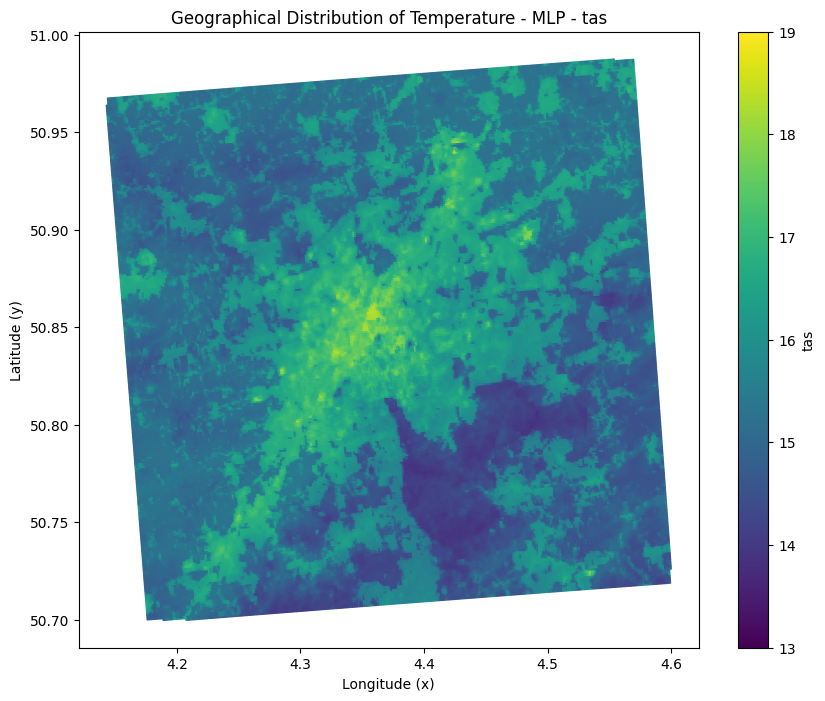

In [73]:
# extract the first timestamp y_pred and plot it
# first_stamp_data = urbclim_pred[(urbclim_pred['time']=="2016-07-01 12:00:00") | (urbclim_pred['time']=="2016-07-01")]
first_stamp_data_mlp = urbclim_pred_mlp[(urbclim_pred_mlp['time']=="2017-07-01 00:00:00")]
tas_min_mlp = first_stamp_data_mlp['tas'].min()
tas_max_mlp = first_stamp_data_mlp['tas'].max()
print("tas min: " ,tas_min_mlp)
print("tas max: " ,tas_max_mlp)
plot_y(first_stamp_data_mlp, 'MLP - tas', 'tas')

In [40]:
# calculate the error matric for corrected era5 with urbclim for test set
urbclim_true = test_set_selected['tas']
era5_true = test_set_selected['t2m_corrected']
urbclim_true_day = test_set_selected[(test_set_selected['time'].dt.hour >= 6) & (test_set_selected['time'].dt.hour < 18)][['tas']]
urbclim_true_night =  test_set_selected[(test_set_selected['time'].dt.hour < 6) | (test_set_selected['time'].dt.hour >= 18)][['tas']]
era5_true_day = test_set_selected[(test_set_selected['time'].dt.hour >= 6) & (test_set_selected['time'].dt.hour < 18)][['t2m_corrected']]
era5_true_night = test_set_selected[(test_set_selected['time'].dt.hour < 6) | (test_set_selected['time'].dt.hour >= 18)][['t2m_corrected']]


In [41]:
calculate_errors(urbclim_true, era5_true)
print("Errors during day:")
calculate_errors(urbclim_true_day['tas'], era5_true_day['t2m_corrected'])
print("Errors during night:")
calculate_errors(urbclim_true_night['tas'], era5_true_night['t2m_corrected'])


Mean Absolute Error (MAE): 0.9105989203665271
Mean Squared Error (MSE): 1.802738099139393
Root Mean Squared Error (RMSE): 1.342660828034911
R-squared (R²): 0.7686938327237061
Errors during day:
Mean Absolute Error (MAE): 0.5083054612297256
Mean Squared Error (MSE): 0.39624445609045195
Root Mean Squared Error (RMSE): 0.6294795120497981
R-squared (R²): 0.9421163756699418
Errors during night:
Mean Absolute Error (MAE): 1.3128923795033283
Mean Squared Error (MSE): 3.2092317421883325
Root Mean Squared Error (RMSE): 1.7914328740391956
R-squared (R²): 0.45983581797041206


tas min:  14.050704614937809
tas max:  15.819034533452603


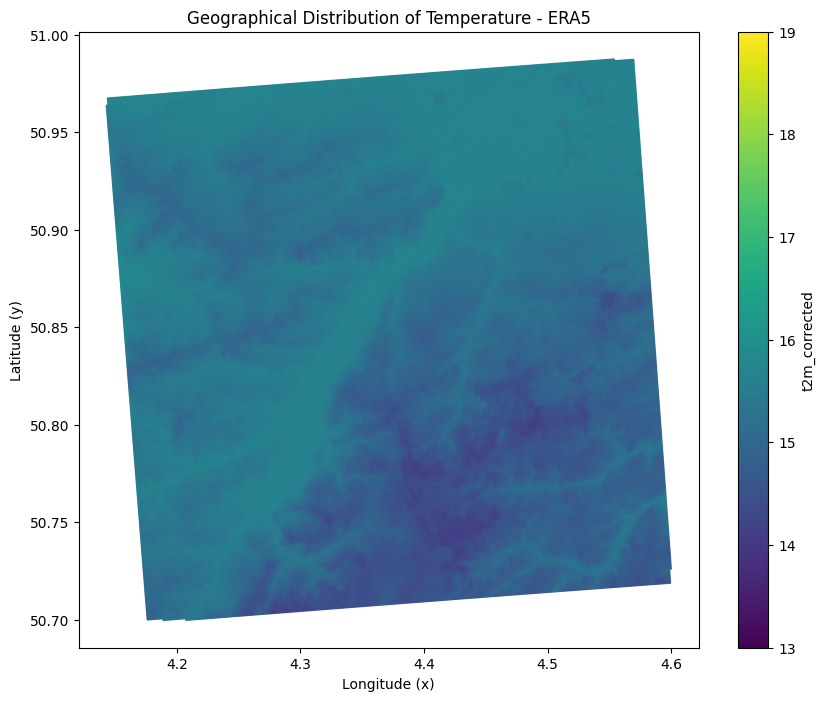

In [72]:
ERA5_plot = test_set_selected[(test_set_selected['time'] == "2017-07-01 00:00:00")][['t2m_corrected','x','y']]
tas_min = ERA5_plot['t2m_corrected'].min()
tas_max = ERA5_plot['t2m_corrected'].max()
print("tas min: " ,tas_min)
print("tas max: " ,tas_max)
plot_y(ERA5_plot, 'ERA5','t2m_corrected')



In [61]:
# first_timestamp_true = urbclim_true_value[(urbclim_true_value['time']=="2016-07-01 00:00:00") | (urbclim_true_value['time']=="2016-07-01")]
first_timestamp_true = test_set_selected[(test_set_selected['time']=="2017-07-01 00:00:00")][['tas','x','y']]
print(first_timestamp_true)
tas_min = first_timestamp_true['tas'].min()
tas_max = first_timestamp_true['tas'].max()
print("tas min: " ,tas_min)
print("tas max: " ,tas_max)
plot_y(first_timestamp_true, 'True data', 'tas')


             tas         x          y
0      15.632135  4.207803  50.700043
1      15.149103  4.209215  50.700110
2      14.975702  4.210626  50.700184
3      15.035272  4.212038  50.700256
4      14.915277  4.213450  50.700325
...          ...       ...        ...
90542  15.303064  4.547782  50.986958
90543  15.286371  4.549203  50.987026
90544  15.476862  4.550624  50.987090
90545  15.270410  4.552045  50.987160
90546  15.791254  4.553465  50.987225

[90547 rows x 3 columns]
tas min:  14.061822509765648
tas max:  17.839501953125023


In [ ]:
models = ['Model 1', 'Model 2', 'Model 3', 'Model 4']
mae = [0.5, 0.7, 0.6, 0.8] # List of MAE values
mse = [0.3, 0.5, 0.4, 0.6] # List of MSE values
rmse = [0.4, 0.6, 0.5, 0.7] # List of RMSE values

# Draw a line graph
plt.figure(figsize=(10, 6))

# Add three different lines
plt.plot(models, mae, marker='o', linestyle='-', label='MAE') # MAE curve
plt.plot(models, mse, marker='s', linestyle='--', label='MSE') # MSE curve
plt.plot(models, rmse, marker='^', linestyle='-.', label='RMSE') # RMSE curve

# Add title and axis labels
plt.title('Error Comparison Across Models')
plt.xlabel('Models')
plt.ylabel('Error Value')

# Show legend
plt.legend()

# Add grid (optional)
plt.grid(True)

# Show chart
plt.show()